In [34]:
#imports 
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix, 
    ConfusionMatrixDisplay,

)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

try:
    from IPython.display import display  
except Exception: 
    display = None



In [35]:
# Fixed seed for reproducibility
SEED = 42
np.random.seed(SEED)
pd.set_option("display.max_columns", 200)

DATA_PATH = Path("clinvar_conflicting.csv")

N_TREES = 150
NGRAM_RANGE = (2, 4)
MAX_FEATURES = 5000
MIN_DF = 5 # For reproducibility 


def header(title):
    print(f"\n{title}\n" + "-" * len(title))

# Some models can output NaNs/inf in edge cases.
def safe_probs(arr):
    p = np.asarray(arr, dtype=np.float32)
    p = np.nan_to_num(p, nan=0.0, posinf=1.0, neginf=0.0)
    return np.clip(p, 0.0, 1.0)

# To keep plotting/metricsrobust.
def metrics_from_probs(y_true, probs, threshold=0.5): # Threshold is fixed at 0.5 for simplicity
    p = safe_probs(probs)
    pred = (p >= threshold).astype(int)
    return {
        "accuracy": float(accuracy_score(y_true, pred)),
        "balanced_acc": float(balanced_accuracy_score(y_true, pred)),
        "f1": float(f1_score(y_true, pred, pos_label=1, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_true, p)),
        "pr_auc": float(average_precision_score(y_true, p)),
    }

def show(df, title, n=None):
    print(f"\n{title}")
    if n is not None:
        df = df.head(n)
    if display is not None:
        display(df)
    else:
        print(df)

def grid(ax):
    ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.5)


In [36]:
# Loading ClinVar style dataset and enforcing a clean binary target (CLASS).
def load_data(path):
    df = pd.read_csv(path, low_memory=False)
    df.columns = [c.strip() for c in df.columns]

    df["CLASS"] = pd.to_numeric(df["CLASS"], errors="coerce")
    df = df.dropna(subset=["CLASS"]).copy()
    df["CLASS"] = df["CLASS"].astype(int)

    df = df.drop_duplicates().replace({pd.NA: np.nan})
    return df

 # Leakage check
def find_leaks(df):
    prefixes = (
        "CLNSIG",
        "CLNSIGINCL",
        "CLNREVSTAT",
        "CLNACC",
        "CLNDN",
        "CLNDNINCL",
        "CLNDISDB",
        "CLNDISDBINCL",
        "CLNVI",
        "CLNVC",
    )

    def bad_prefix(col):
        up = col.upper()
        return any(up.startswith(p) for p in prefixes)

    prefix_cols = [c for c in df.columns if bad_prefix(c)]

    # drop text columns that frequently contain obvious label words
    token_re = re.compile(
        r"(?:\bpathogenic\b|\bbenign\b|\buncertain(?:\s+significance)?\b|\bconflict\w*\b|\breview\w*\b)",
        re.I,
    )

    token_cols = []
    for c in df.select_dtypes(include="object").columns:
        s = df[c].dropna().astype(str)
        if s.empty:
            continue
        hit_rate = float(s.str.contains(token_re, regex=True, na=False).mean())
        if hit_rate >= 0.02:
            token_cols.append(c)

    return sorted(set(prefix_cols + token_cols))

def split(df):
    y = df["CLASS"].values
    X = df.drop(columns=["CLASS"]).replace({pd.NA: np.nan})

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=SEED,
        stratify=y,
    )
    return X_train, X_test, y_train, y_test


In [37]:
# Preprocessing 
def prep_features(train_df, test_df, num_cols, cat_cols):
    # numeric: median impute + robust scale (fit on train only)
    train_num = train_df[num_cols].copy()
    test_num = test_df[num_cols].copy()

    med = train_num.median(numeric_only=True)
    train_num = train_num.fillna(med)
    test_num = test_num.fillna(med)

    scaler = RobustScaler()
    train_num = scaler.fit_transform(train_num.values).astype(np.float32)
    test_num = scaler.transform(test_num.values).astype(np.float32)

    if cat_cols:
        train_cat = train_df[cat_cols].copy()
        test_cat = test_df[cat_cols].copy()

        for c in cat_cols:
            mode_val = train_cat[c].mode(dropna=True)
            fill_val = mode_val.iloc[0] if not mode_val.empty else "MISSING"
            train_cat[c] = train_cat[c].fillna(fill_val)
            test_cat[c] = test_cat[c].fillna(fill_val)

        train_ohe = pd.get_dummies(train_cat, columns=cat_cols, drop_first=False)
        test_ohe = pd.get_dummies(test_cat, columns=cat_cols, drop_first=False)
        test_ohe = test_ohe.reindex(columns=train_ohe.columns, fill_value=0)

        train_cat = train_ohe.values.astype(np.float32)
        test_cat = test_ohe.values.astype(np.float32)
        cat_names = list(train_ohe.columns)
    else:
        train_cat = np.zeros((len(train_df), 0), dtype=np.float32)
        test_cat = np.zeros((len(test_df), 0), dtype=np.float32)
        cat_names = []

    train_mat = np.hstack([train_num, train_cat])
    test_mat = np.hstack([test_num, test_cat])
    names = list(num_cols) + cat_names
    return train_mat, test_mat, names

#Simple text representation
def rows_to_text(df, cols):
    def join_one(r):
        parts = []
        for c in cols:
            v = r.get(c)
            if pd.notna(v):
                parts.append(f"{c}={v}")
        return " ".join(parts)

    return df.apply(join_one, axis=1)


In [38]:
# Loading data, checking class distribution, and removing leaky columns
header("LOAD")
df = load_data(DATA_PATH)
print(f"Shape after cleanup: {df.shape}")

counts = df["CLASS"].value_counts().sort_index()
dist = (
    counts.rename_axis("class")
    .reset_index(name="count")
    .assign(percent=lambda d: (d["count"] / d["count"].sum() * 100).round(1))
)
show(dist, "Class distribution")

header("LEAK CHECK")
leaks = find_leaks(df)
df = df.drop(columns=leaks, errors="ignore").copy()
print(f"Dropped leaky columns: {len(leaks)}")
if leaks:
    show(pd.DataFrame({"leaky_column": leaks}), "Leaky columns (preview)", n=25)



LOAD
----
Shape after cleanup: (65188, 46)

Class distribution


,class,count,percent
0,0,48754,74.8
1,1,16434,25.2



LEAK CHECK
----------
Dropped leaky columns: 8

Leaky columns (preview)


,leaky_column
0,CLNDISDB
1,CLNDISDBINCL
2,CLNDN
3,CLNDNINCL
4,CLNSIGINCL
5,CLNVC
6,CLNVI
7,PolyPhen


In [39]:
# Splitting the data, preparing curated features, and training baseline models
header("SPLIT")
X_train, X_test, y_train, y_test = split(df)
show(
    pd.DataFrame(
        [{"split": "train", "n_samples": len(X_train)}, {"split": "test", "n_samples": len(X_test)}]
    ),
    "Split sizes",
)

header("CURATED FEATURES")
num_cols = [
    c for c in ["CADD_PHRED", "CADD_RAW", "LoFtool", "BLOSUM62", "AF_ESP", "AF_EXAC", "AF_TGP"]
    if c in X_train.columns
]
cat_cols = [c for c in ["Consequence", "IMPACT", "SYMBOL"] if c in X_train.columns]

show(
    pd.DataFrame(
        [
            {"type": "numeric", "features": ", ".join(num_cols)},
            {"type": "categorical", "features": ", ".join(cat_cols)},
        ]
    ),
    "Using",
)

train_a, test_a, feat_names = prep_features(X_train, X_test, num_cols, cat_cols)

rf = RandomForestClassifier(
    n_estimators=N_TREES,
    class_weight="balanced",
    random_state=SEED,
    n_jobs=-1,
)
rf.fit(train_a, y_train);

lr = LogisticRegression(
    solver="liblinear",
    max_iter=1000,
    class_weight="balanced",
    random_state=SEED,
)
lr.fit(train_a, y_train);



SPLIT
-----

Split sizes


,split,n_samples
0,train,52150
1,test,13038



CURATED FEATURES
----------------

Using


,type,features
0,numeric,"CADD_PHRED, CADD_RAW, LoFtool, BLOSUM62, AF_ES..."
1,categorical,"Consequence, IMPACT, SYMBOL"



TEXT BASELINE
-------------

Text columns


,text_cols
0,REF
1,ALT
2,Codons
3,Amino_acids
4,Consequence
5,IMPACT



RESULTS
-------

Metrics (sorted by ROC-AUC)


,model,accuracy,balanced_acc,f1,roc_auc,pr_auc
0,RF_curated,0.764228,0.638280,0.451071,0.775044,0.496030
1,LR_curated,0.633379,0.670899,0.506606,0.725785,0.432692
2,LR_text,0.508207,0.541637,0.384409,0.567983,0.297198



CONFUSION MATRIX (RF, threshold=0.5)
------------------------------------


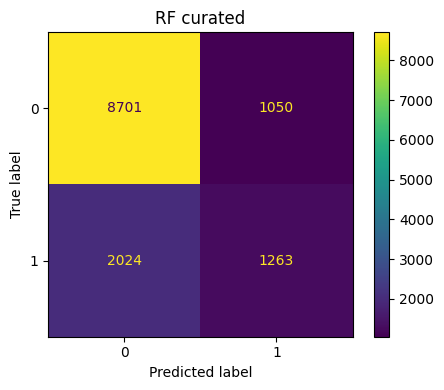


RF IMPORTANCE
-------------

Top 20 features


,feature,importance
0,CADD_RAW,0.138846
1,CADD_PHRED,0.125963
2,AF_EXAC,0.115200
3,AF_TGP,0.077621
4,AF_ESP,0.076274
5,LoFtool,0.051188
6,BLOSUM62,0.026914
7,IMPACT_HIGH,0.007412
8,Consequence_missense_variant,0.003927
9,SYMBOL_ATM,0.003916


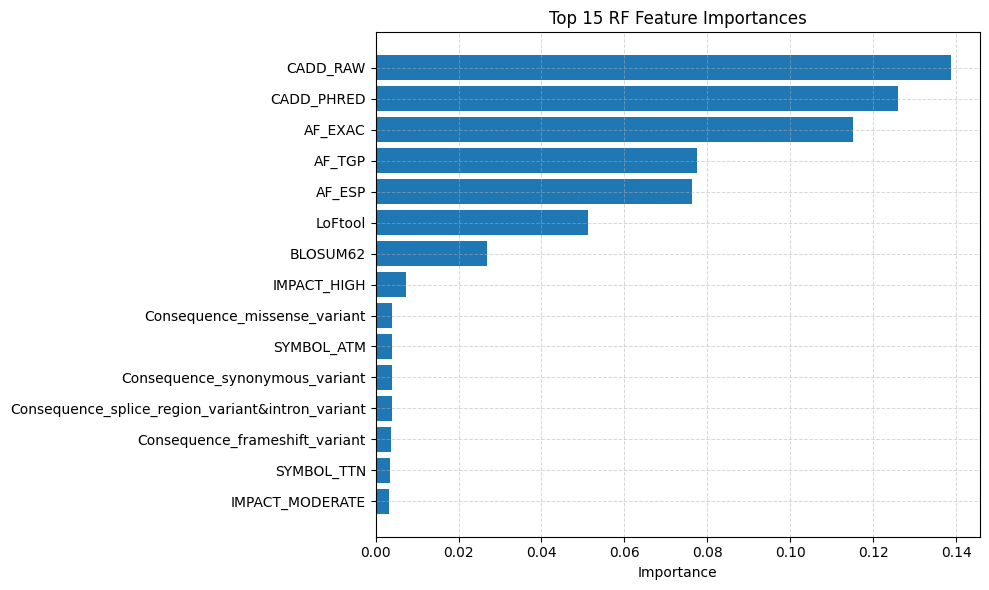


ABLATION (drop SYMBOL)
----------------------

Ablation metrics


,model,accuracy,balanced_acc,f1,roc_auc,pr_auc
0,RF_with_SYMBOL,0.764228,0.638280,0.451071,0.775044,0.496030
1,RF_no_SYMBOL,0.743979,0.594088,0.364916,0.735499,0.442671


In [41]:
# Text baseline
header("TEXT BASELINE")
text_cols = [c for c in ["REF", "ALT", "Codons", "Amino_acids", "Consequence", "IMPACT"] if c in X_train.columns]
show(pd.DataFrame({"text_cols": text_cols}), "Text columns")

tr_text = rows_to_text(X_train, text_cols)
te_text = rows_to_text(X_test, text_cols)

# Text baseline
vec = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=NGRAM_RANGE,
    min_df=MIN_DF,
    max_features=MAX_FEATURES,
    dtype=np.float32,
)
train_b = vec.fit_transform(tr_text)
test_b = vec.transform(te_text)

lr_text = LogisticRegression(
    solver="liblinear",
    max_iter=1000,
    class_weight="balanced",
    random_state=SEED,
)
lr_text.fit(train_b, y_train)

header("RESULTS")
p_rf = rf.predict_proba(test_a)[:, 1]
p_lr = lr.predict_proba(test_a)[:, 1]
p_txt = lr_text.predict_proba(test_b)[:, 1]

out = pd.DataFrame(
    [
        {"model": "RF_curated", **metrics_from_probs(y_test, p_rf)},
        {"model": "LR_curated", **metrics_from_probs(y_test, p_lr)},
        {"model": "LR_text", **metrics_from_probs(y_test, p_txt)},
    ]
).sort_values("roc_auc", ascending=False)

show(out, "Metrics (sorted by ROC-AUC)")

header("CONFUSION MATRIX (RF, threshold=0.5)")
cm = confusion_matrix(y_test, (p_rf >= 0.5).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, values_format="d")
ax.set_title("RF curated")
plt.tight_layout()
plt.show()


header("RF IMPORTANCE")
imp = pd.DataFrame({"feature": feat_names, "importance": rf.feature_importances_})
imp = imp.sort_values("importance", ascending=False).reset_index(drop=True)
show(imp.head(20), "Top 20 features")

top = imp.head(15)
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(top)), top["importance"].values)
ax.set_yticks(range(len(top)))
ax.set_yticklabels(top["feature"].values)
ax.invert_yaxis()
ax.set_xlabel("Importance")
ax.set_title("Top 15 RF Feature Importances")
grid(ax)
plt.tight_layout()
plt.show()

# Testing an ablation by dropping SYMBOL to see its impact on performance
if "SYMBOL" in cat_cols:
    header("ABLATION (drop SYMBOL)")
    cat2 = [c for c in cat_cols if c != "SYMBOL"]
    tr2, te2, _, = prep_features(X_train, X_test, num_cols, cat2)

    rf2 = RandomForestClassifier(
        n_estimators=N_TREES,
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1,
    )
    rf2.fit(tr2, y_train)
    p_rf2 = rf2.predict_proba(te2)[:, 1]

    ab = pd.DataFrame(
        [
            {"model": "RF_with_SYMBOL", **metrics_from_probs(y_test, p_rf)},
            {"model": "RF_no_SYMBOL", **metrics_from_probs(y_test, p_rf2)},
        ]
    )
    show(ab, "Ablation metrics")



ROC / PR
--------


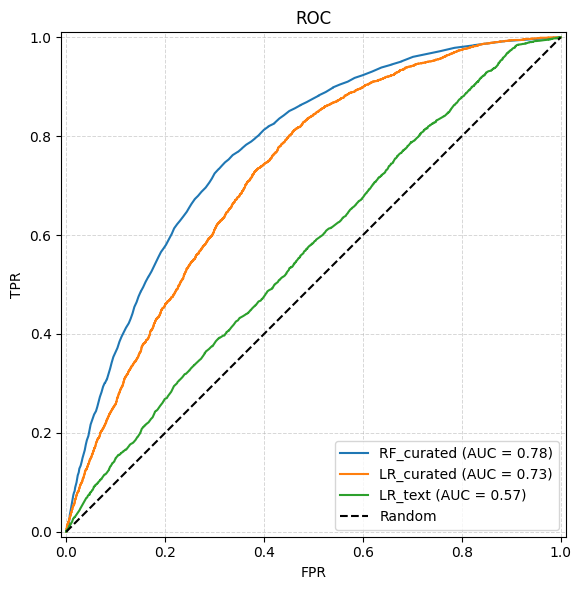

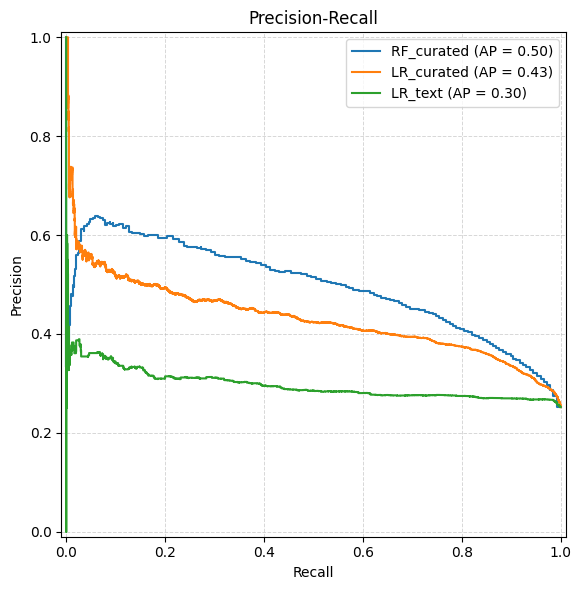

In [26]:
# Plot ROC and Precision-Recall curves for a visual comparison 
header("ROC / PR")
p_rf = safe_probs(p_rf)
p_lr = safe_probs(p_lr)
p_txt = safe_probs(p_txt)

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, p_rf, name="RF_curated", ax=ax)
RocCurveDisplay.from_predictions(y_test, p_lr, name="LR_curated", ax=ax)
RocCurveDisplay.from_predictions(y_test, p_txt, name="LR_text", ax=ax)
ax.plot([0, 1], [0, 1], "k--", label="Random")
ax.set_title("ROC")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
grid(ax)
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
PrecisionRecallDisplay.from_predictions(y_test, p_rf, name="RF_curated", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, p_lr, name="LR_curated", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, p_txt, name="LR_text", ax=ax)

ax.set_title("Precision-Recall")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
grid(ax)
ax.legend()
plt.tight_layout()
plt.show()




## Takeaways
-Curated annotation features (CADD scores, allele frequencies, and impact/consequence) perform noticeably better than the quick TF-IDF text baseline.
    
-Random Forest shows the strongest overall ranking performance in this setup (ROC-AUC and PR-AUC), while Logistic Regression serves as a solid, simpler baseline.
    
-The SYMBOL feature significantly boosts performance, but this also suggests the model may be learning gene-level priors rather than purely variant-level signals.

## Limitations
-Results are based on a single stratified train/test split, so performance may vary with a different split.
    
-No hyperparameter tuning or threshold optimization was performed, models mostly use default settings.
    
-The SYMBOL feature may act as a shortcut (gene-level prior), which could inflate performance and limit generalization to unseen genes.